<h1>The purpose of this notebook is to check which features might be best, i.e., they separate better the data. This is in order to avoid to iterate over all combinations of the features and saving time.
Each point on a plot represents a <b>segment</b>.
<br>
Take these results very carefully for two reasons: we have a total of around 1400 segments, less than 10% of the data we will process, and visual inspection is ok but is no matenatical proof
</h1>

In [1]:
import os, pandas as pd, numpy as np
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from sod.evaluation import open_dataset

dataframe = open_dataset(os.path.join(os.getcwd(), '..', 'dataset', 'dataset.hdf'))

Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/dataset/dataset.hdf

                                 segments
ok                                331,121
outl. (wrong inv. file)             1,452
outl. (cha. resp. acc <-> vel)    393,777
outl. (gain X100 or X0.01)        331,121
outl. (gain X10 or X0.1)          331,121
outl. (gain X2 or X0.5)           331,121
total                           1,719,713

Normalizing numeric columns (floats only)
                   min median   max      NAs segs1-99 stas1-99
snr               0.00   0.00  1.00   11,542    6,566      367
magnitude         0.00   0.40  1.00        0    7,869      355
distance_km       0.00   0.35  1.00        0    6,624      351
amp@0.5hz         -inf   0.62  1.94   13,899    6,612      254
amp@1hz           -inf   0.64  2.05   12,384    6,618      263
amp@2hz           -inf   0.63  2.11   11,799    6,622      253
amp@5hz           -inf   0.45  2.69   11,630    6,622      223
amp@10hz          -inf   0.54  

In [12]:
from sod.evaluation import drop_duplicates, info

print(info(dataframe))

for columns in [
    ['delta_pga', 'delta_pgv'],
    # ['delta_pga', 'delta_pgv', 'noise_psd@5sec'],
    # ['amp@0.5hz', 'amp@1hz', 'amp@2hz', 'amp@5hz', 'amp@10hz', 'magnitude', 'distance_km']
]:
    for ddigits in [5,4,3,2,1]:
        print('\nEXPERIMENTING DROP DUPLICATES (%d decimal digits) ON %s' % (ddigits, str(columns)))
        drop_duplicates(dataframe, columns, decimals=ddigits)

                                 segments
ok                                331,121
outl. (wrong inv. file)             1,452
outl. (cha. resp. acc <-> vel)    393,777
outl. (gain X100 or X0.01)        331,121
outl. (gain X10 or X0.1)          331,121
outl. (gain X2 or X0.5)           331,121
total                           1,719,713

EXPERIMENTING DROP DUPLICATES (5 decimal digits) ON ['delta_pga', 'delta_pgv']

Duplicated per class removed
                                 segments
ok                                311,841
outl. (wrong inv. file)             1,449
outl. (cha. resp. acc <-> vel)     96,592
outl. (gain X100 or X0.01)        319,709
outl. (gain X10 or X0.1)          319,688
outl. (gain X2 or X0.5)           319,618
total                           1,368,897

EXPERIMENTING DROP DUPLICATES (4 decimal digits) ON ['delta_pga', 'delta_pgv']

Duplicated per class removed
                                 segments
ok                                291,190
outl. (wrong inv. file) 

In [21]:
import matplotlib.pyplot as plt
from sod.evaluation import is_outlier
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

PLOT_RATIO = 0.2  # there is too much data, show only this ratio
LOW_SNR = False

def plot(df, col_x, col_y, col_z=None, axis_lim=None):
    '''axis_lim is the quantile of data to be shown on the axis: 0.95 will display the axis min and max
    at 0.05 quantile of the data distribution and 0.95 quantile, respectuvely'''
    if LOW_SNR:
        df = df[df['snr'] > 3]
    is_outl = is_outlier(df)
    df = df[:int(len(df) * PLOT_RATIO)]
    # df = df[(~df['low_snr']) & ~(df['saturated'])]
    df_ok = df[~is_outl]
    df_no = df[is_outl]
    
    if axis_lim is None:
        minx, maxx = (df[col_x]).min(), (df[col_x]).max()
        miny, maxy = (df[col_y]).min(), (df[col_y]).max()
        minz, maxz = (None, None)
        if col_z is not None:
            miny, maxy = (df[col_z]).min(), (df[col_z]).max()
    else:
        minx, maxx = df[col_x].quantile([1-axis_lim, axis_lim])
        miny, maxy = df[col_y].quantile([1-axis_lim, axis_lim])
        minz, maxz = (None, None)
        if col_z is not None:
            minz, maxz = df[col_z].quantile([1-axis_lim, axis_lim])

    
    # divide the dataframe in bins. Take PLOT_RATIO randomly points for each bin
    indices = set()
    for c in [col_x, col_y] + ([] if col_z is None else [col_z]):
        bins = pd.cut(df[c], 10)
        for _, df_ in df.groupby(bins):
            if df_.empty:
                continue
            num = int(len(df_) * PLOT_RATIO)
            if num < 1:
                num = 1
            indices |= set(df_.sample(num).index.values)
    
    l = len(df)
    df = df.loc[list(indices), : ]
    print("%d -> %d " % (len(df), l))
    fig = plt.figure(figsize=(15, 15))

    def newaxes(index):
        row, col = 3, 3
        if col_z is not None:
            ax = fig.add_subplot(row, col, index, projection='3d')
        else:
            ax = fig.add_subplot(row, col, index)
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        ax.set_xlabel(col_x)
        ax.set_ylabel(col_y)
        if col_z is not None:
            ax.set_zlabel(col_z)
            ax.set_zlim(minz, maxz)
        ax.grid(True)
        return ax
    
    def scatter(ax, df, color):
        kwargs = {'edgecolors': 'none', 's': 81}
        if col_z is None:
            ax.scatter(df[col_x], df[col_y], color=color, **kwargs)
        else:
            ax.scatter(df[col_x], df[col_y], df[col_z], color=color, **kwargs)
        
    alpha = 0.1
    
    ax = newaxes(1)
    scatter(ax, df_ok, [0, 0.1, 0.75, alpha])
    ax.set_title('GOOD: %d segs' % len(df_ok))
    
    ax = newaxes(2)
    df_no_ = df_no[df_no['modified'].str.contains('CHARESP')]
    scatter(ax, df_no_, [0.75, 0.1, 0, alpha])
    ax.set_title('BAD (CH.RESP. SWITCH ACC<->VEL): %d segs' % len(df_no_))

    ax = newaxes(3)
    df_no_ = df_no[df_no['modified'].str.contains('INVFILE:')]
    scatter(ax, df_no_, [0, 0.75, 0.1, alpha])
    ax.set_title('BAD (WRONG INVENTORY): %d segs' % len(df_no_))
    
    color = [0.75, 0.5, 0, alpha]

    for i, label in enumerate([
        'STAGEGAIN:X100.0',
        'STAGEGAIN:X10.0',
        'STAGEGAIN:X2.0',
        'STAGEGAIN:X0.01',
        'STAGEGAIN:X0.1',
        'STAGEGAIN:X0.5'
    ], 4):
        ax = newaxes(i)
        df_no_ = df_no[df_no['modified'].str.contains(label)]
        scatter(ax, df_no_, color)
        ax.set_title('BAD (%s): %d segs' % (label, len(df_no_)))
    
#     ax = newaxes(5)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X10.0')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAINx5): %d segs' % len(df_no_))
    
#     ax = newaxes(6)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X2.0')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAINx2): %d segs' % len(df_no_))
    
#     ax = newaxes(7)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X0.1')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAIN/10): %d segs' % len(df_no_))
    
#     ax = newaxes(8)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X0.2')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAIN/5): %d segs' % len(df_no_))
    
#     ax = newaxes(9)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X0.5')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAIN/2): %d segs' % len(df_no_))
    
    space = .4 if col_z is not None else .25
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=space, hspace=space)
    

<h3>First try: PGA vs PGV. Observations on the plots below:
    <ul>
        <li> The symmetry of data along the line y=x (roughly speaking) seems to show that calculations are consistent. Still, you can see how two features separate the data better than a single one (try to project the point on either the x or y axis, and you see that the data blue vs rest is not very separable)
        <li>Changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue). As expected, the distribution of x10 (first bottom plot on the left) says something more than the other two
    </ul></h3>

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


119969 -> 343942 


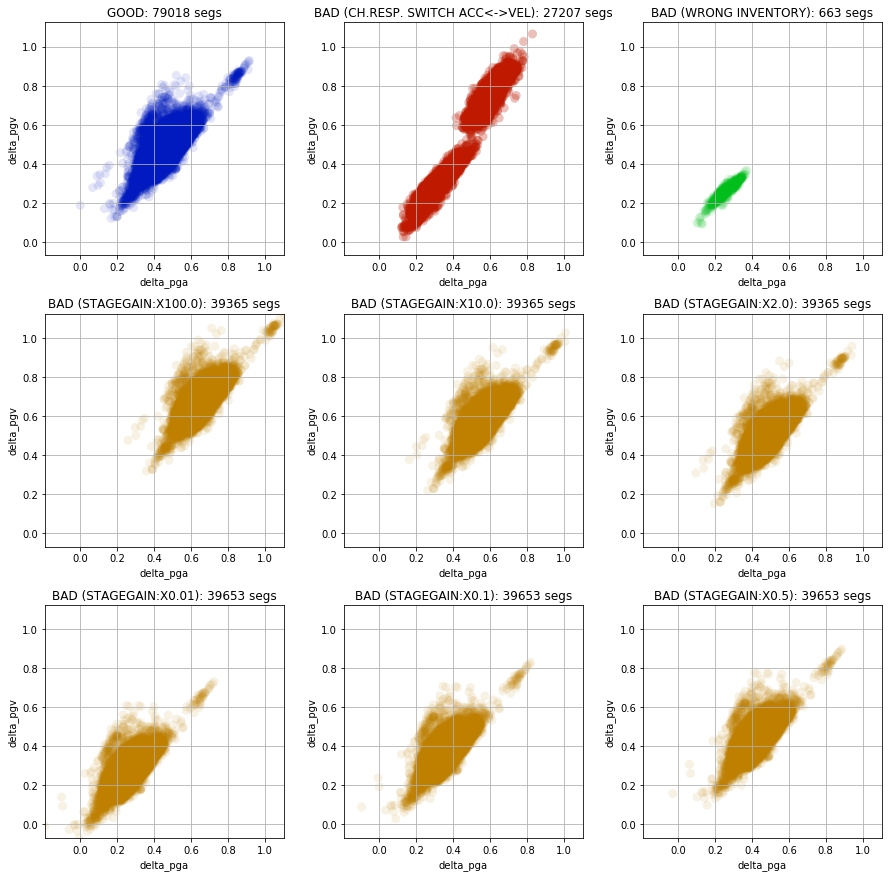

In [22]:
plot(dataframe, 'delta_pga', 'delta_pgv', axis_lim=None)

<h3>Ok let's replace PGV with psd@10sec on the y axis. Observations on the plots below:
    <ul>
        <li>psd@10sec seems to well separate the good vs bad data (plots on the first row).
        <li>Still, changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue)
    </ul>
</h3>

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


122146 -> 343942 


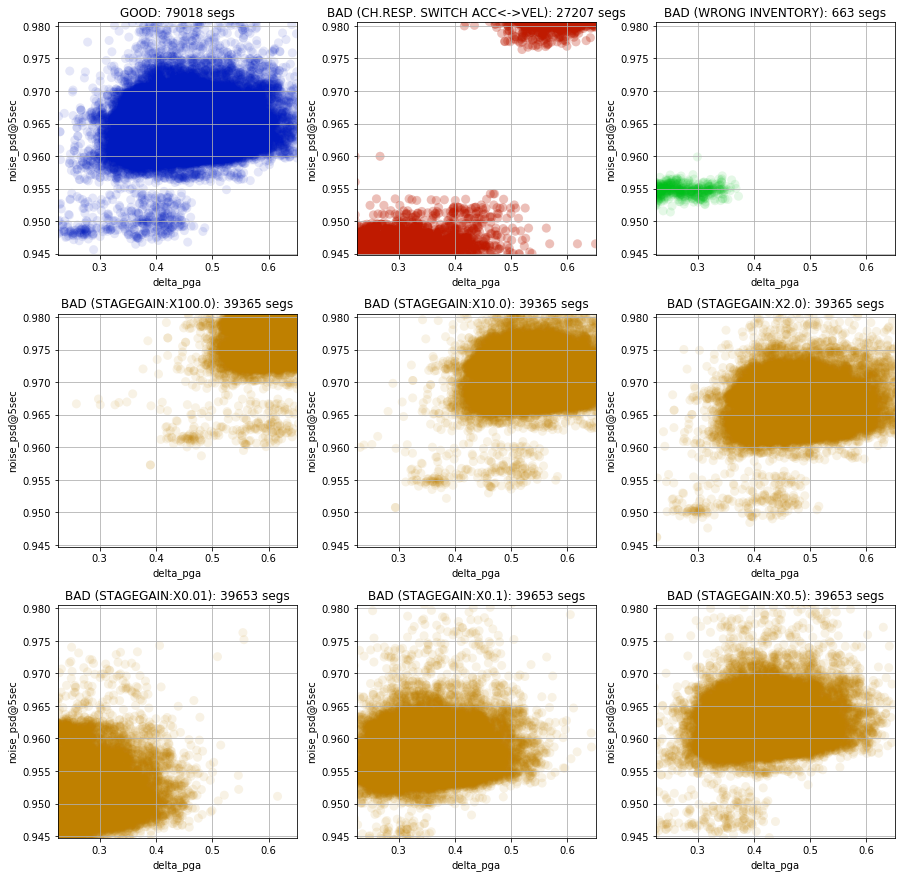

In [23]:
plot(dataframe, 'delta_pga', 'noise_psd@5sec', axis_lim=.95)  # with delta_pgv does not change a lot

<h3>What if we use log10(pga) instead of delta_pga?
    <!-- <ul>
        <li>At low periods we have more antropic noise, but apparently if we have a really wrong inventory (first row of plots) psd@0.1sec seem to perform as psd@10sec for good vs bad data (plots on the first row).
        <li>But, changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue), and in this case psd@10sec performs better
    </ul> -->
</h3>

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


121993 -> 343942 


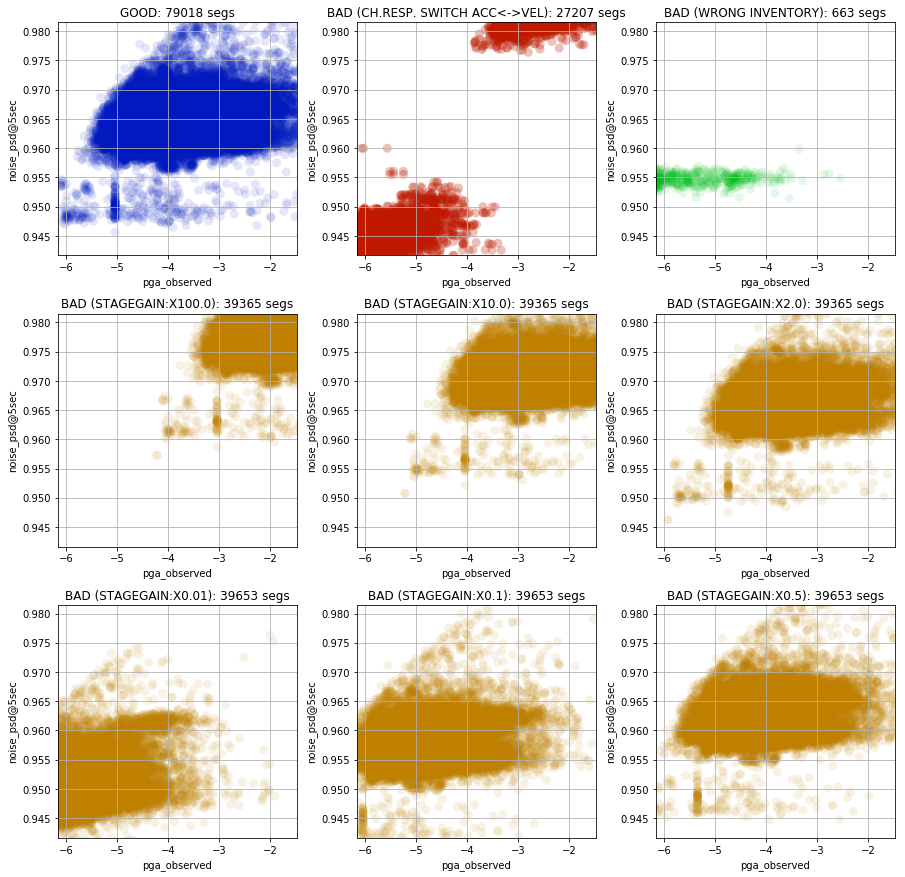

In [24]:
dfr = dataframe[['pga_observed', 'noise_psd@5sec', 'outlier', 'modified']].copy()
dfr['pga_observed'] = np.log10(dfr['pga_observed'].abs())
plot(dfr, 'pga_observed', 'noise_psd@5sec', axis_lim=.96)  # with delta_pgv does not change a lot

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


119895 -> 343942 


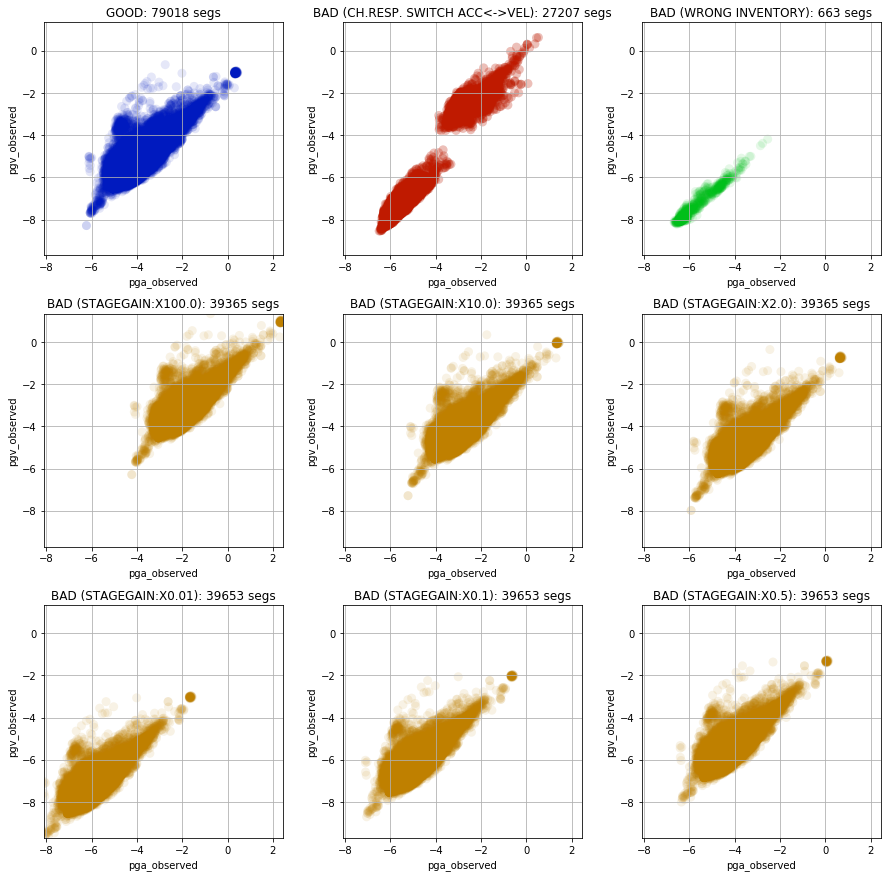

In [27]:
# FROM NOW ON WE CAN DELETE STUFF!!!!!
# FROM NOW ON WE CAN DELETE STUFF!!!!!
# FROM NOW ON WE CAN DELETE STUFF!!!!!
# FROM NOW ON WE CAN DELETE STUFF!!!!!
# FROM NOW ON WE CAN DELETE STUFF!!!!!
# FROM NOW ON WE CAN DELETE STUFF!!!!!
# FROM NOW ON WE CAN DELETE STUFF!!!!!
# FROM NOW ON WE CAN DELETE STUFF!!!!!

# ALL WHAT IS DONE BELOW IS OUTDATED!!!!!

# CHECKIT
# CHECKIT!!!!!



dfr = dataframe[['pga_observed', 'pgv_observed', 'outlier', 'modified']].copy()
dfr['pga_observed'] = np.log10(dfr['pga_observed'].abs())
dfr['pgv_observed'] = np.log10(dfr['pgv_observed'].abs())
plot(dfr, 'pga_observed', 'pgv_observed', axis_lim=None)

<h3>What if we add snr?
    <!-- <ul>
        <li>At low periods we have more antropic noise, but apparently if we have a really wrong inventory (first row of plots) psd@0.1sec seem to perform as psd@10sec for good vs bad data (plots on the first row).
        <li>But, changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue), and in this case psd@10sec performs better
    </ul> -->
</h3>

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


123882 -> 343942 


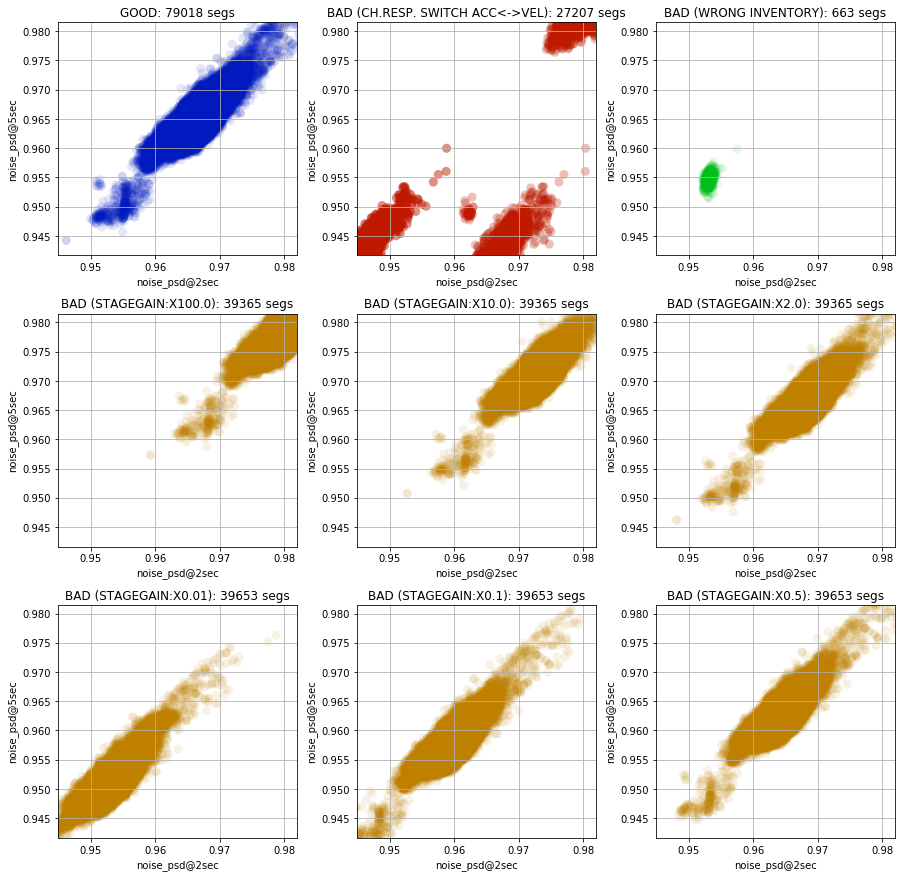

In [37]:
plot(dataframe, 'noise_psd@2sec', 'noise_psd@5sec', axis_lim=.96)

<h3>What if we use psd@0.1sec (the shortest period we have). Let's replace PGA with psd@0.1sec on the x axis. Observations on the plots below:
    <ul>
        <li>At low periods we have more antropic noise, but apparently if we have a really wrong inventory (first row of plots) psd@0.1sec seem to perform as psd@10sec for good vs bad data (plots on the first row).
        <li>But, changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue), and in this case psd@10sec performs better
    </ul>
</h3>

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


122105 -> 343942 


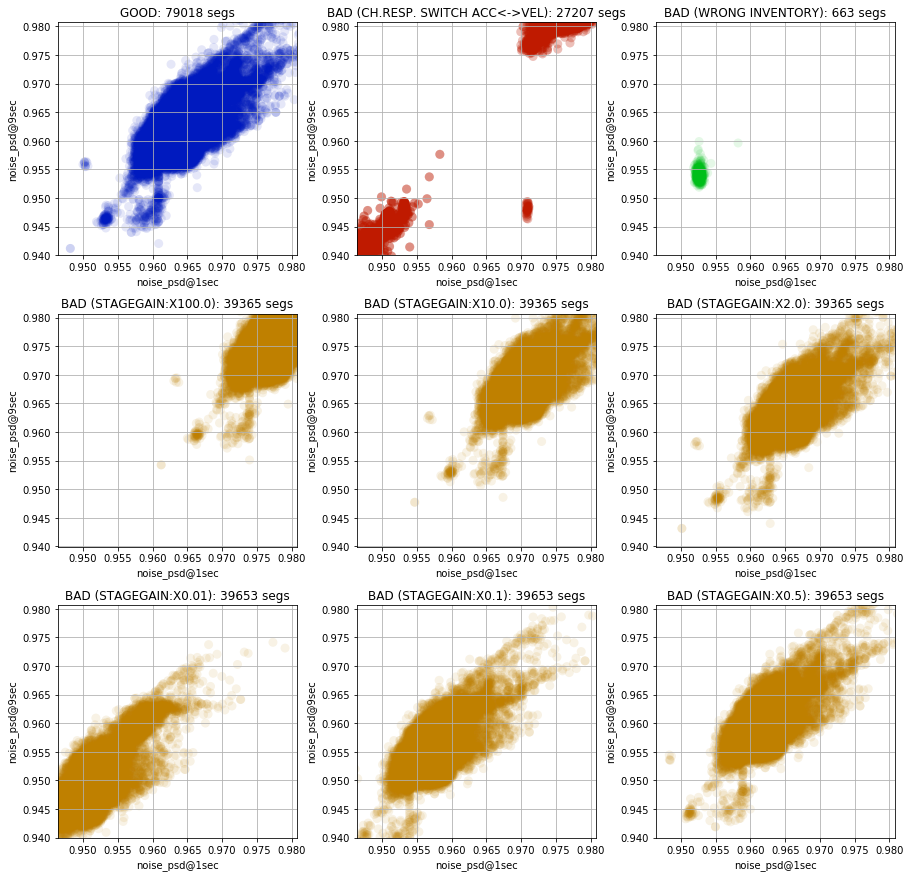

In [38]:
plot(dataframe, 'noise_psd@1sec', 'noise_psd@9sec', axis_lim=.96)

<h3>Another try (not shown, irrelevant): let's psd@10sec (the lagest period we have) with some information on the signal (psd refers to the noise). Becasue psd is on the largest period, I take also the amplitude spectrum on the largest frequency (amp@10hz), 
    using the log10 of the amplitudes (Dino observation, ask why) <b>But let's keep in mind that the earthquake amplitude is a function of magnitude and distance</b>, so these plots are just a try. Observations on the plots below:
</h3>

<h3>Last try: let's try to summarize the three most promising features
</h3>

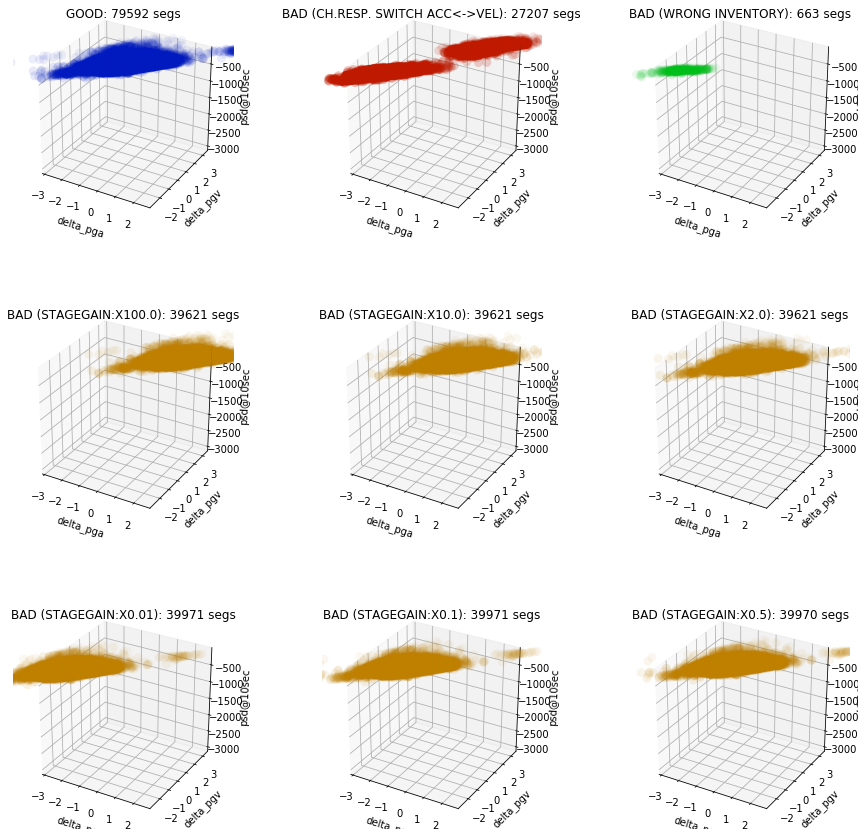

In [17]:
plot(dforig.copy(), 'delta_pga', 'delta_pgv', 'psd@10sec', axis_lim=.99)  # with delta_pgv does not change a lot

In [ ]:
to try:
    1. normalization
    
    2. All combinations:

    delta_pga
    delta_pgv
    psd@10sec
    delta_pga, delta_pgv,
    delta_pga, delta_pgv, psd@10sec,
    delta_pga, psd@10sec, snr
    delta_pga, delta_pgv, snr
    delta_pga, delta_pgv, psd@10sec, snr
    
    then without other info, only spectral information:
    distance_km, magnitude, amp@0.5hz, amp@1hz, amp@2hz, amp@5hz, amp@10hz
    distance_km, magnitude, amp@0.5hz, amp@1hz, amp@2hz, amp@5hz, amp@10hz, snr
    distance_km, magnitude, amp@0.5hz, amp@1hz, amp@2hz, amp@5hz, amp@10hz, psd@10Hz, snr
    
    
    
